# NASDAQ Stock Indices

#### March 2017
<u>Statistics 141B</u>: Data and Web Technologies<br>
<u>Contributors</u>: Jeremy Weidner, Weizhou Wang, Audrey Chu, and Yuji Mori

### Abstract

To study NASDAQ stock prices for the technology, finance, health care, and energy industry sectors across time.  With the application of python and utilization of the Yahoo! Finance API, Yahoo Query Language (YQL), and New York Times API, we will gather and clean out a dataset for a time period of ten years for approximately 1770 companies.  Our data will incorporate the closing prices for each day and then average these prices for each respective sector.  In analyzing the stock prices, we will use interactive data visualization as well as attempt to create a time series ARIMA (Autoregressive Integrated Moving Average) model.

### Questions of Interest
- How do stock prices differ among industry sectors?
- Can we explain unusual trends in past prices by relating them to major historical events?
- Which month for which sector has the least volatility?

### Table of Contents
* [Data Extraction](#1)
* [Data Visualization](#2)
* ...
* ...
* ...

In [4]:
import sys
import csv
import json
import requests
import requests_cache
import numpy as np
import pandas as pd
from pprint import pprint 
from datetime import datetime
import matplotlib.pyplot as plt
import math
import matplotlib as mpl
%matplotlib inline
import seaborn as sns
sns.set_style('white', {"xtick.major.size": 2, "ytick.major.size": 2})
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71","#f4cae4"]
sns.set_palette(sns.color_palette(flatui,7))
import missingno as msno

# Price Plots
import plotly
plotly.tools.set_credentials_file(username="audchu",api_key="fPSZjEJ6wqYjzolZ8wNI")
import plotly.plotly as py
import plotly.graph_objs as go
from datetime import datetime
from pandas_datareader import data,wb

# Streaming Plot
from plotly.grid_objs import Grid,Column
import time

# Accessing the NY Times API
from nytimesarticle import articleAPI

# Webscraping and Text Processing
from bs4 import BeautifulSoup
import urllib2
from urllib2 import urlopen
import string
import nltk
import regex as re
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import wordcloud
import pickle

# Time Series
from  __future__ import print_function
from scipy import stats
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot

In [2]:
requests_cache.install_cache('cache')

In [3]:
# Yahoo YQL API
PUBLIC_API_URL = 'https://query.yahooapis.com/v1/public/yql'
OAUTH_API_URL = 'https://query.yahooapis.com/v1/yql'
DATATABLES_URL = 'store://datatables.org/alltableswithkeys'

def myreq(ticker, start, end):
    '''
    input ticker & dates as strings form 'YYYY-MM-DD'
    '''
    params = {'format':'json',
             'env':DATATABLES_URL}
    query = 'select * from yahoo.finance.historicaldata where symbol = "{}" and startDate = "{}" and endDate = "{}"'.format(ticker,start, end)
    params.update({'q':query})
    req = requests.get(PUBLIC_API_URL, params=params)
    req.raise_for_status()
    req = req.json()
    if req['query']['count'] > 0:
        result = req['query']['results']['quote']
        return result
    else:
        pass

In [4]:
def price2(ticker):
    """
    Return closing prices for stocks from years 2006 to 2016.
    """
    
    date=[]
    price=[]
    report = []
    
    years = [2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016]
    for x in range(len(years)):
        c = myreq(ticker,'{}-01-01'.format(years[x]),'{}-12-31'.format(years[x]))
        try:
        
            for i in range(0,len(c)):
                date.append(pd.to_datetime(c[i]["Date"]))
                price.append(float(c[i][u'Close']))
                datef = pd.DataFrame(date)
                pricef = pd.DataFrame(price)
                table1 = pd.concat([datef,pricef],axis = 1)
                table1.columns = ['Date', ticker]
                table1 = table1.set_index("Date")
            
        except Exception:
            table1 = pd.DataFrame()
    
    return table1

## Data Extraction<a class="anchor" id="1"></a>

We begin by extracting our main dataset which comes from the Yahoo Finance API. We extracted stock closing prices for each stock currently in the Nasdaq. We do this via requests using a YQL query to the historical data table of the API. Not every stock currently in the Nasdaq was around from when we started extracting in 2006 and so they're values are NA until they IPO. The weights of these additions when they happen are not believed to be of substantial impact to our analysis of price because we aggregate over 4 sectors across roughly 1700 stocks. If you look closely at the function it iterates by year because if you request over 364 values there is an undocumented error where you get returned an empty JSON object.

List of companies on NASDAQ can be found here: http://www.nasdaq.com/screening/company-list.aspx

In [5]:
csv = pd.read_csv('./companylist.csv')
newcsv = csv[csv["Sector"].isin(["Finance", "Energy","Health Care","Technology"])].reset_index()
del newcsv["index"]

In [6]:
whole_list = newcsv['Symbol']

In [7]:
for l in whole_list:
    get = price2(l)
    try:
        df = pd.concat([df,get],axis = 1)    # concat. by column 
    except NameError:
        df = pd.DataFrame(get)    # initialize automatically
# SAVE THE RESULT LOCALLY:
df.to_pickle('mydf')

"\nfor l in whole_list:\n    get = price2(l)\n    try:\n        df = pd.concat([df,get],axis = 1)    # concat. by column \n    except NameError:\n        df = pd.DataFrame(get)    # initialize automatically\n# SAVE THE RESULT LOCALLY:\ndf.to_pickle('mydf')\n"

In [7]:
df = pd.read_pickle('mydf')

In [10]:
df.head()

,PIH,FCCY,SRCE,VNET,TWOU,JOBS,ABEO,...,ZIONW,ZIOP,ZIXI,ZGNX,ZSAN,ZYNE,ZNGA
Date,,,,,,,,,,,,,,,
2006-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-01-03,NaN,21.499973,25.830002,NaN,NaN,14.95,0.51,...,NaN,3.60,1.93,NaN,NaN,NaN,NaN
2006-01-04,NaN,21.499973,25.659998,NaN,NaN,14.79,0.47,...,NaN,4.00,2.04,NaN,NaN,NaN,NaN
2006-01-05,NaN,20.999980,25.820004,NaN,NaN,16.15,0.46,...,NaN,4.00,2.20,NaN,NaN,NaN,NaN
2006-01-06,NaN,20.519969,25.950002,NaN,NaN,17.08,0.45,...,NaN,4.25,2.09,NaN,NaN,NaN,NaN


In [8]:
final = newcsv.reset_index()
df_long = df.transpose()
sector  = final[['Symbol','Sector']]
sector = sector.set_index('Symbol')

In [9]:
final = df_long.join(sector)

In [10]:
final.head()

,2006-01-02 00:00:00,2006-01-03 00:00:00,2006-01-04 00:00:00,2006-01-05 00:00:00,2006-01-06 00:00:00,2006-01-09 00:00:00,2006-01-10 00:00:00,2006-01-11 00:00:00,2006-01-12 00:00:00,2006-01-13 00:00:00,...,2016-12-20 00:00:00,2016-12-21 00:00:00,2016-12-22 00:00:00,2016-12-23 00:00:00,2016-12-26 00:00:00,2016-12-27 00:00:00,2016-12-28 00:00:00,2016-12-29 00:00:00,2016-12-30 00:00:00,Sector
PIH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.601000,7.583000,7.400000,7.650000,NaN,7.400000,7.400000,7.250000,7.800000,Finance
FCCY,NaN,21.499973,21.499973,20.999980,20.519969,20.249976,19.999980,20.369968,20.000001,20.779999,...,17.549999,17.350000,17.280001,17.350000,NaN,18.100000,18.250000,18.000000,18.700001,Finance
SRCE,NaN,25.830002,25.659998,25.820004,25.950002,25.999997,25.999997,25.999997,25.940002,25.989997,...,45.000000,44.439999,44.400002,44.200001,NaN,44.740002,44.700001,45.330002,44.660000,Finance
VNET,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.320000,7.100000,6.990000,7.050000,NaN,7.150000,7.090000,6.960000,7.010000,Technology
TWOU,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,33.049999,32.099998,30.740000,30.809999,NaN,30.549999,30.340000,29.770000,30.150000,Technology


In [11]:
# Take median of each group for recorded date
med_sector = final.groupby('Sector').median().reset_index('Sector')
med_sector = med_sector.set_index('Sector')
med_sector = med_sector.dropna(thresh=4, axis = 1)        # Drop if a column less than two non-NAs

In [12]:
# Dates as index for plotting
# Columns are now the Sector medians
med_T = med_sector.transpose()

## The Dataset Head

In [13]:
med_T.head()

Sector,Energy,Finance,Health Care,Technology
2006-01-03 00:00:00,13.565,23.250000,6.945685,11.245
2006-01-04 00:00:00,13.460,23.309999,6.925000,11.655
2006-01-05 00:00:00,13.750,23.459999,6.990000,11.770
2006-01-06 00:00:00,13.700,23.400000,7.019992,11.775
2006-01-09 00:00:00,13.790,23.500000,7.100000,12.050


In [17]:
len(med_T)

2769

Above is the head of our final dataframe.  Indexed by the the dates from 2006 to 2016, the dataframe contains the median closing prices across all NASDAQ companies grouped by sector.  Note that prices have minimal changes across consecutive days, as expected.  It would be unusual to see a price change of more than 1.0 in one day.  To further investigate the stock price changes in the last decade, we decided to produce visual diagnostics.  

## Data Visualization<a class="anchor" id="2"></a>

### Interactive Price Plots

In [14]:
def ts_slider(sector,sec_name):
    trace = go.Scatter(x=med_T.index,y=sector)
    data = [trace]
    layout = dict(
        title=sec_name + ' Sector Median Closing Prices: Time series with Range Slider',
        xaxis=dict(
            rangeselector=dict(
                buttons=list([
                    dict(count=1,
                         label='1m',
                         step='month',
                         stepmode='backward'),
                    dict(count=6,
                         label='6m',
                         step='month',
                         stepmode='backward'),
                    dict(count=1,
                        label='YTD',
                        step='year',
                        stepmode='todate'),
                    dict(count=1,
                        label='1y',
                        step='year',
                        stepmode='backward'),
                    dict(step='all')
                ])
            ),
            rangeslider=dict(),
            type='date'
        )
    )

    fig = dict(data=data, layout=layout)
    return py.iplot(fig)

In [15]:
ts_slider(med_T.Energy,"Energy")

Above is one example of an interactive time series slider plot for the Energy sector.  Closing prices are highest in May 2007 at \$25.56 whereas loweset closing price is at \$3.49 in February 2016.  This plot allows to look further into detail.  Using the buttons as provided, we can pinpoint the exact day with the highest and lowest prices.  The highest price is actually at \$25.71 occurs on on May 15, 2007 and the lowest price occurs at \$2.93 on February 10, 2016 and February 16, 2016.  Additionally, looking at the plot by year, it is graphically obvious that the year 2008 had the highest drop in stock prices.  This is reasonable and aligns with the Recession of 2008.  There is also a noticable drop in 2014 and 2015; however, an explanation behind these years is not as clear as that of 2008.

For that reason, let's try some more plots.

#### Specifically, are Energy's general trends of fluctuation consistent across the other three sectors?

In [16]:
Energy = go.Scatter(x=med_T.index,y=med_T.Energy, name='Energy')
Finance = go.Scatter(x=med_T.index,y=med_T.Finance, name='Finance')
HealthCare = go.Scatter(x=med_T.index,y=med_T['Health Care'], name='Health Care')
Technology = go.Scatter(x=med_T.index,y=med_T.Technology, name='Technology')


data = [Energy, Finance, HealthCare, Technology]
layout = dict(
    title='Median Closing Prices: Time series with Range Slider',
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                    label='1m',
                    step='month',
                    stepmode='backward'),
                dict(count=6,
                    label='6m',
                    step='month',
                    stepmode='backward'),
                dict(count=1,
                    label='YTD',
                    step='year',
                    stepmode='todate'),
                dict(count=1,
                    label='1y',
                    step='year',
                    stepmode='backward'),
                dict(step='all')
            ])
        ),
        rangeslider=dict(),
        type='date'
    )
)

fig = dict(data=data, layout=layout)
py.iplot(fig)

Above is an overlaid interactive plot with closing price data for all four sectors.  Other sectors seem to be consistent with Energy sector between the years 2008 and 2010.  The Energy sector differs the most from other sectors in terms of variation.  Specifically, when looking between May 2008 and November 2008, the Energy sector is somewhat bimodal, with the first peak in July 2008 and second in October 2008.  In contrast, the other three sectors remain consistent with their closing prices.  

This peaks the question: <b>what happened in this time period that the Energy sector was specifically affected?</b>  We already expect all stock prices to drop signficantly during the recession, but why are there sector-specific or unusually inconstitent fluctuations. To accurately measure these flucations relative to sector, we need to normalize the changes through volatility analysis.

### Volatility Analysis

In [17]:
# New dataframe for the difference between each day as a percentage
delta_df = pd.DataFrame()
for sect in med_T.columns:
    delta_df[sect] = np.log(med_T[sect].shift(1)) - np.log(med_T[sect])
delta_df.columns = map(lambda name: '{} Changes'.format(name),med_T.columns)

In [18]:
delta_df.head()

,Energy Changes,Finance Changes,Health Care Changes,Technology Changes
2006-01-03,NaN,NaN,NaN,NaN
2006-01-04,0.007771,-0.002577,0.002982,-0.035812
2006-01-05,-0.021316,-0.006414,-0.009343,-0.009819
2006-01-06,0.003643,0.002561,-0.004282,-0.000425
2006-01-09,-0.006548,-0.004264,-0.011333,-0.023086


A more accurate representation to measure trends or changes in sector is to take the difference of closing prices for each day.  This will show the percentage change in price relative to the previous day.  Mathematically this is,<br>

<center>$growth_t = \frac{price_{t+1} - price_t}{price_t}$   or   $increase_t = \frac{price_{t} - price_{t-1}}{price_t}$</center>

The formulas above measure the differences but can lead to differing conclusions.  The most efficient way to model the growth of the stock is through log differences,
<center>$change_t = log(price_t) - log(price_{t-1})$</center>

where $price_t$ represents the median closing price at time t for a sector.  Log differences are advantageous because they can be interpreted as the percentage change in a stock price and they do not depend on the fraction denominator.

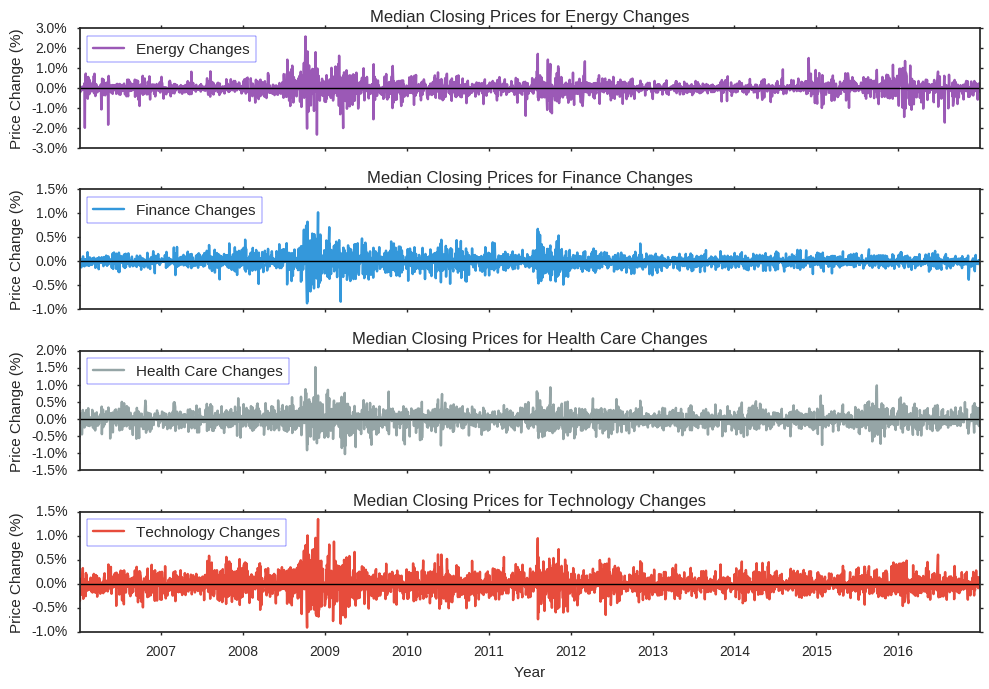

In [19]:
plot_cols = list(delta_df)

# 2 axes for 2 subplots
fig, axes = plt.subplots(4,1, figsize=(10,7), sharex=True)
#delta_df[plot_cols].plot(subplots=True, ax=axes)
delta_df[plot_cols].plot(subplots=True, ax=axes)
#plt.ylim([-0.20,0.150])


for ax, col in zip(axes, plot_cols):
    # add titles
    ax.set_title('Median Closing Prices for ' + col)

    
    # lets add horizontal zero lines
    ax.axhline(0, color='k', linestyle='-', linewidth=1)
    
    # add axis labels
    ax.set_ylabel('Price Change (%)')
    ax.set_xlabel('Year')
    
    # upgrade axis tick labels
    yticks = ax.get_yticks()
    ax.set_yticklabels(['{:3.2}%'.format(x*10) for x in yticks]);
    
    # add cool legend
    ax.legend(loc='upper left', fontsize=11, frameon=True).get_frame().set_edgecolor('blue')  

plt.tight_layout()


In [20]:
# Stock price spike the most?
abs(delta_df).idxmax()

Energy Changes        2008-10-06
Finance Changes       2008-12-01
Health Care Changes   2008-11-19
Technology Changes    2008-12-01
dtype: datetime64[ns]

You'll notice that for all sectors, the biggest changes in closing prices occur between 2008 and 2010, which supports our initial comments.  However, by looking at the changes rather than actual prices, this plot shows that there is on average changes average between -1.0% and +1.5%, with the exception of Energy's changes ranging from -3.0% and +3.0%.  This provides better insight to how much change occurs in relation to former price trends.

Additionally, we see that the highest absolute value of price change for Energy occurred on October 6, 2008, for Finance occurred on December 1, 2008, for Health Care occurred on November 19, 2008, and for Technology occurred on December 1, 2008.  2008 is clearly an interested period because of the recession and these extremes or maximum of price changes prove that.  All maximums are located withing a few months of each other, and interestingly enough, Finance and Technology actually have maximums on the same day.

Although direction of changes are consisten across sectors, <b>Energy</b> seems to always have the highest volatility.  Higher volatility in Energy is due to the sector's large portion of business in commodities market including oil, minerals, and wood.  Specifically, the sector consists of monopolies and oligopolies that have higher pricing power since they are the sole sellers.  The slow adjustment caused by the supply and demand rule are not are pronounced in this specific sector.

### Periods of Interest for Major Price Changes

In addition to the 2008 Recession, we want to know what other periods in the past ten years had extreme or unusual behavior.  Here, we take the average using months (rather than days) as units to obtain a more global or broader view of changes.

In [21]:
med_T.index= pd.to_datetime(med_T.index)
avg_month = med_T.groupby([med_T.index.year, med_T.index.month]).mean()
avg_month.head()

Sector     Energy    Finance  Health Care  Technology
2006 1  14.183000  23.605500     7.159611   11.686500
     2  15.404737  23.857619     7.334495   11.895263
     3  14.699130  23.953911     7.656957   12.523913
     4  15.968421  23.920786     7.665814   13.029474
     5  17.850000  23.418863     7.096370   12.887273

In [22]:
# DF for the difference between each month's average:
delta_avg = pd.DataFrame()

for sect in avg_month.columns:
    delta_avg[sect] = np.log(avg_month[sect].shift(1)) - np.log(avg_month[sect])
delta_avg.columns = map(lambda name: '{} Changes'.format(name),avg_month.columns)

col = []
for i in range(len(delta_avg)):
    dt = delta_avg.index[i] + (10, 10, 10, 10)
    dt_obj = datetime(*dt[0:6])
    col.append(pd.to_datetime(dt_obj))

In [23]:
delta_avg['Timestamp'] = col

In [24]:
delta_avg = delta_avg.set_index('Timestamp')

In [25]:
delta_avg

,Energy Changes,Finance Changes,Health Care Changes,Technology Changes
Timestamp,,,,
2006-01-10 10:10:10,NaN,NaN,NaN,NaN
2006-02-10 10:10:10,-0.082631,-0.010624,-0.024133,-0.017706
2006-03-10 10:10:10,0.046887,-0.004028,-0.043026,-0.051500
2006-04-10 10:10:10,-0.082825,0.001384,-0.001156,-0.039574
2006-05-10 10:10:10,-0.111390,0.021206,0.077187,0.010974
2006-06-10 10:10:10,-0.022834,0.014280,0.042359,0.089027
2006-07-10 10:10:10,-0.010213,0.006151,0.071923,0.061305
2006-08-10 10:10:10,0.041277,-0.007239,0.080343,0.004462
2006-09-10 10:10:10,0.035880,-0.020717,-0.092788,-0.032277


In [43]:
plot_cols = list(delta_avg)

# 2 axes for 2 subplots
fig, axes = plt.subplots(4,1, figsize=(10,7), sharex=True)
#delta_df[plot_cols].plot(subplots=True, ax=axes)
delta_avg[plot_cols].plot(subplots=True, ax=axes)
#plt.ylim([-0.20,0.150])


for ax, col in zip(axes, plot_cols):
    # add titles
    ax.set_title('Monthly Closing Prices for ' + col)

    
    # lets add horizontal zero lines
    ax.axhline(0, color='k', linestyle='-', linewidth=1)
    
    # add axis labels
    ax.set_ylabel('Price Change (%)')
    ax.set_xlabel('Year')
    
    # upgrade axis tick labels
    yticks = ax.get_yticks()
    ax.set_yticklabels(['{:3.2}%'.format(x*10) for x in yticks]);
    
    # add cool legend
    ax.legend(loc='upper left', fontsize=11, frameon=True).get_frame().set_edgecolor('blue')  

plt.tight_layout()

"\nplot_cols = list(delta_avg)\n\n# 2 axes for 2 subplots\nfig, axes = plt.subplots(4,1, figsize=(10,7), sharex=True)\n#delta_df[plot_cols].plot(subplots=True, ax=axes)\ndelta_avg[plot_cols].plot(subplots=True, ax=axes)\n#plt.ylim([-0.20,0.150])\n\n\nfor ax, col in zip(axes, plot_cols):\n    # add titles\n    ax.set_title('Monthly Closing Prices for ' + col)\n\n    \n    # lets add horizontal zero lines\n    ax.axhline(0, color='k', linestyle='-', linewidth=1)\n    \n    # add axis labels\n    ax.set_ylabel('Price Change (%)')\n    ax.set_xlabel('Year')\n    \n    # upgrade axis tick labels\n    yticks = ax.get_yticks()\n    ax.set_yticklabels(['{:3.2}%'.format(x*10) for x in yticks]);\n    \n    # add cool legend\n    ax.legend(loc='upper left', fontsize=11, frameon=True).get_frame().set_edgecolor('blue')  \n\nplt.tight_layout()\n"

In [26]:
(abs(delta_avg).iloc[1:,:].quantile(q=0.90, axis=0))

Energy Changes         0.163191
Finance Changes        0.059207
Health Care Changes    0.118481
Technology Changes     0.084176
Name: 0.9, dtype: float64

In [27]:
peak = delta_avg[(abs(delta_avg) >= 0.163191).any(axis=1)]

In [28]:
peak.head()

,Energy Changes,Finance Changes,Health Care Changes,Technology Changes
Timestamp,,,,
2008-08-10 10:10:10,0.271934,-0.048996,-0.069831,-0.033595
2008-10-10 10:10:10,0.483709,0.131039,0.320536,0.340418
2008-11-10 10:10:10,0.192015,0.068335,0.228251,0.217602
2009-03-10 10:10:10,0.176872,0.069709,0.133102,0.045064
2009-04-10 10:10:10,-0.167232,-0.116181,-0.137381,-0.224170


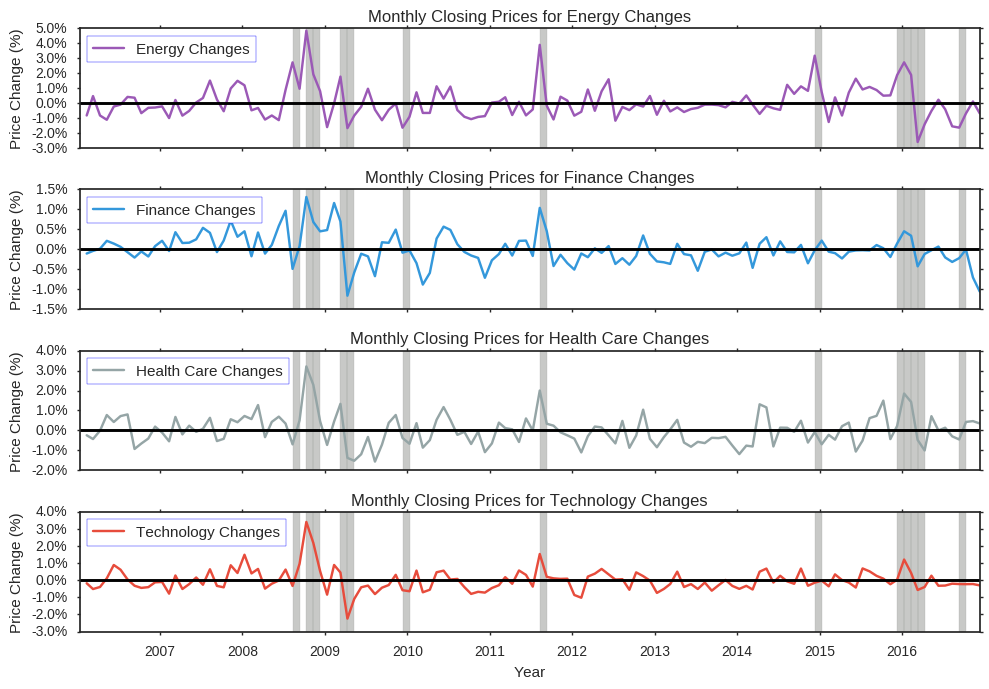

In [29]:
plot_cols = list(delta_avg)

fig, axes = plt.subplots(4,1, figsize=(10,7), sharex=True)
delta_avg[plot_cols].plot(subplots=True, ax=axes)

for shade in range(len(peak)):
    peak_bgn = peak.index[shade]
    if peak.index[shade].month == 12:
        year = peak.index[shade].year+1
        end = (year, 1, 10, 10, 10, 10)
        dt_obj = datetime(*end[0:6])
        peak_end = pd.to_datetime(dt_obj)
        
    else:
        mo = peak.index[shade].month + 1
        end = (peak.index[shade].year, mo, 10, 10, 10, 10)
        dt_obj = datetime(*end[0:6])
        peak_end = pd.to_datetime(dt_obj)
        
    for ax in axes:
        ax.axvspan(peak_bgn, peak_end, color=sns.xkcd_rgb['grey'], alpha=.5)
    
        ax.axhline(0, color='k', linestyle='-', linewidth=1)


for ax, col in zip(axes, plot_cols):
    ax.set_title('Monthly Closing Prices for ' + col)
    
    ax.set_ylabel('Price Change (%)')
    ax.set_xlabel('Year')
    
    yticks = ax.get_yticks()
    ax.set_yticklabels(['{:3.2}%'.format(x*10) for x in yticks]);
    
    ax.legend(loc='upper left', fontsize=11, frameon=True).get_frame().set_edgecolor('blue')  

plt.tight_layout()     

On a larger scale, looking at average changes per month, we see that range of changes now differ more between sectors.  Specifically, the range of changes for Technology is now between -3.0% and 4.0%.  This tells us that on a monthly average, changes are bigger than that of days.  Even looking at prices based on monthly averages, we see that Energy still has the biggest change from -3.0% to 5.0%.  

Let's try to see what happens in other sectors during periods of high volality of any sector.  Our threshold here will be the 90th percentile of absolute value of changes as shown below.  We will take the highest of these values to be more inclusive.  The periods of high volatility are shaded above.  In addition to the years between 2008 and 2010, the year 2016 also has unusualy behavior.  There is a signficant drop in average monthly price change for the Energy sector.  Looking at the plots below it, we see that there is a similiar pattern with other interests.  The smallest drop during this 2016 time period is for the Finance sector.

In [44]:
plot_cols = list(med_T)

fig, axes = plt.subplots(4,1, figsize=(10,7), sharex=True)
med_T[plot_cols].plot(subplots=True, ax=axes)

for shade in range(len(peak)):
    peak_bgn = peak.index[shade]
    if peak.index[shade].month == 12:
        year = peak.index[shade].year+1
        end = (year, 1, 10, 10, 10, 10)
        dt_obj = datetime(*end[0:6])
        peak_end = pd.to_datetime(dt_obj)
        
    else:
        mo = peak.index[shade].month + 1
        end = (peak.index[shade].year, mo, 10, 10, 10, 10)
        dt_obj = datetime(*end[0:6])
        peak_end = pd.to_datetime(dt_obj)
        
    for ax in axes:
        ax.axvspan(peak_bgn, peak_end, color=sns.xkcd_rgb['grey'], alpha=.5)
    
        ax.axhline(0, color='k', linestyle='-', linewidth=1)

"\nplot_cols = list(med_T)\n\nfig, axes = plt.subplots(4,1, figsize=(10,7), sharex=True)\nmed_T[plot_cols].plot(subplots=True, ax=axes)\n\nfor shade in range(len(peak)):\n    peak_bgn = peak.index[shade]\n    if peak.index[shade].month == 12:\n        year = peak.index[shade].year+1\n        end = (year, 1, 10, 10, 10, 10)\n        dt_obj = datetime(*end[0:6])\n        peak_end = pd.to_datetime(dt_obj)\n        \n    else:\n        mo = peak.index[shade].month + 1\n        end = (peak.index[shade].year, mo, 10, 10, 10, 10)\n        dt_obj = datetime(*end[0:6])\n        peak_end = pd.to_datetime(dt_obj)\n        \n    for ax in axes:\n        ax.axvspan(peak_bgn, peak_end, color=sns.xkcd_rgb['grey'], alpha=.5)\n    \n        ax.axhline(0, color='k', linestyle='-', linewidth=1)\n"

In [30]:
peak

,Energy Changes,Finance Changes,Health Care Changes,Technology Changes
Timestamp,,,,
2008-08-10 10:10:10,0.271934,-0.048996,-0.069831,-0.033595
2008-10-10 10:10:10,0.483709,0.131039,0.320536,0.340418
2008-11-10 10:10:10,0.192015,0.068335,0.228251,0.217602
2009-03-10 10:10:10,0.176872,0.069709,0.133102,0.045064
2009-04-10 10:10:10,-0.167232,-0.116181,-0.137381,-0.224170
2009-12-10 10:10:10,-0.164439,-0.008523,-0.037643,-0.058359
2011-08-10 10:10:10,0.388879,0.103690,0.199786,0.153049
2014-12-10 10:10:10,0.316577,-0.002436,-0.008372,-0.014644
2015-12-10 10:10:10,0.186521,0.014430,0.022265,0.002597


## Which month has the highest volatility?  In which month would it be best to invest?

In [31]:
abs_delta_df = abs(delta_df)
months = abs_delta_df.groupby(delta_df.index.month).sum()
months

,Energy Changes,Finance Changes,Health Care Changes,Technology Changes
1,5.579697,2.292274,3.983668,3.575874
2,5.153948,1.725488,3.177925,2.995240
3,5.517229,2.258931,4.191325,3.491156
4,4.583842,1.896602,3.660335,3.011856
5,5.179666,1.909797,3.654547,3.306427
6,4.531683,2.211246,3.878905,3.338665
7,4.570591,1.928904,3.694508,3.224373
8,5.905949,2.439180,3.975516,3.614457
9,5.347203,2.091582,3.754380,3.259025
10,6.048092,2.669991,4.596439,4.065775


In [32]:
months["total"] = months.sum(axis=1)

In [33]:
sns.set_style("white")
sns.set_context({"figure.figsize": (20, 10)})

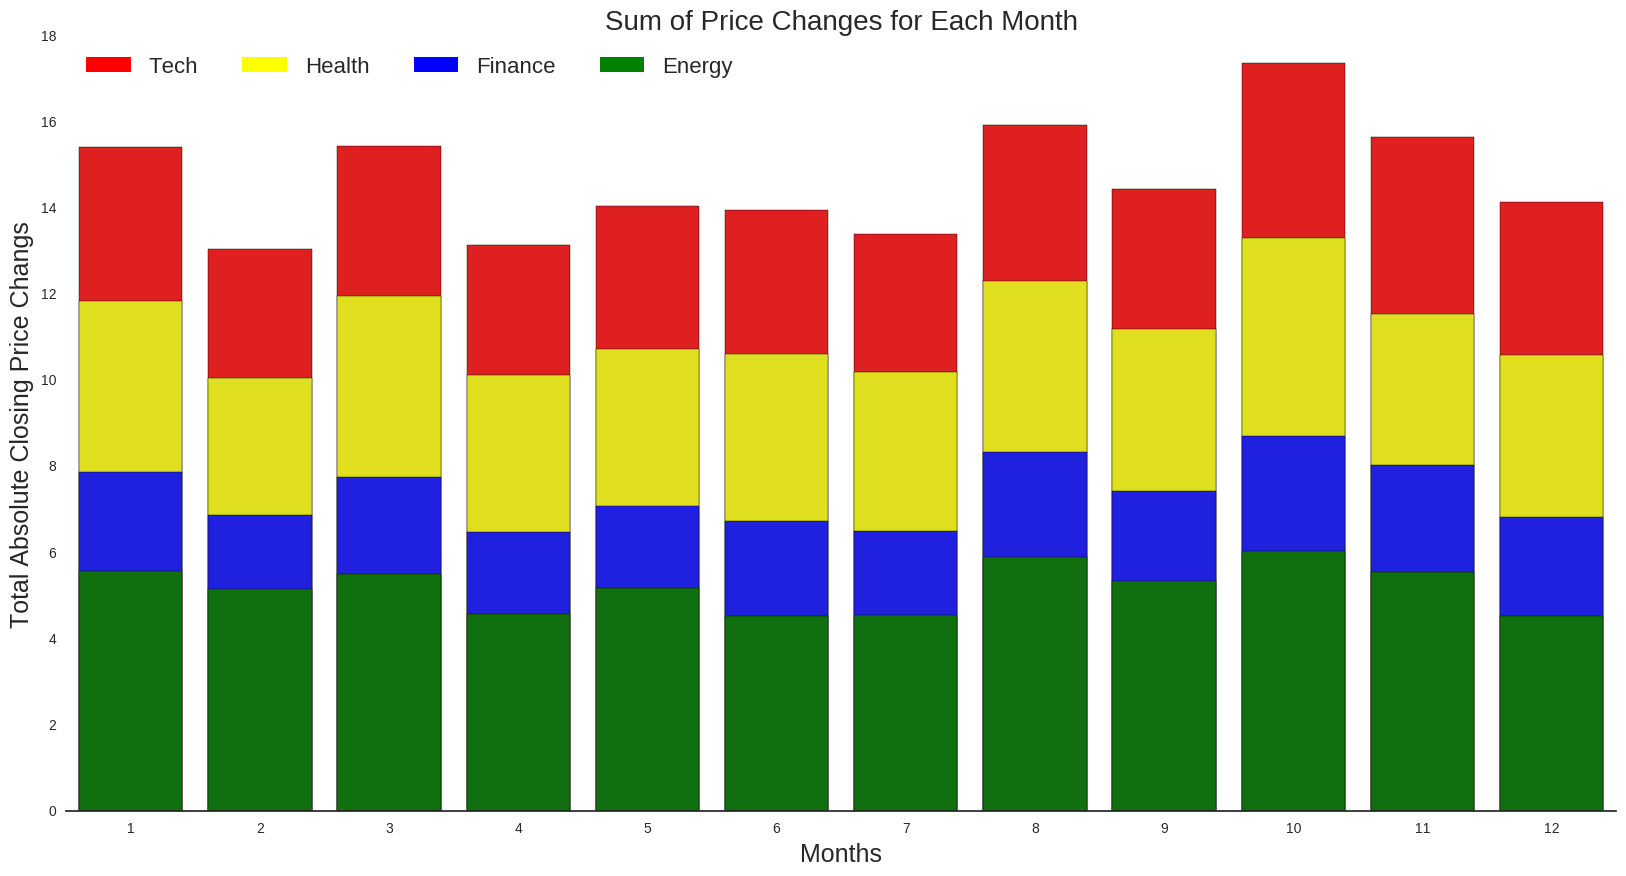

In [34]:
sns.barplot(x = months.index, y = months.total, color = "red")
health_plot = sns.barplot(x = months.index, y = months['Health Care Changes']+months['Energy Changes']+months['Finance Changes'], color = "yellow")
fin_plot = sns.barplot(x = months.index, y = months['Finance Changes']+months['Energy Changes'], color = "blue")
eng_plot = sns.barplot(x = months.index, y = months['Energy Changes'], color = "green")

tech_bar = plt.Rectangle((0,0),1,1,fc="red", edgecolor = 'none')
health_bar = plt.Rectangle((0,0),1,1,fc='yellow',  edgecolor = 'none')
fin_bar = plt.Rectangle((0,0),1,1,fc='blue',  edgecolor = 'none')
eng_bar = plt.Rectangle((0,0),1,1,fc='green',  edgecolor = 'none')

l = plt.legend([tech_bar, health_bar, fin_bar, eng_bar], ['Tech', 'Health', 'Finance', 'Energy'], loc=0, ncol = 4, prop={'size':16})
l.draw_frame(False)

#Optional code - Make plot look nicer
sns.despine(left=True)
eng_plot.set_ylabel("Total Absolute Closing Price Changs", fontsize=18)
eng_plot.set_xlabel("Months", fontsize=18)

plt.title('Sum of Price Changes for Each Month', fontsize=20)

It turns out overall, October (month 10) has the highest total sum of changes.  We see a generally lower sum from February to July.  As for specific sectors, there is a similar pattern across months.  Februrary has the lowest sum of changes per sector and overall.  This can be explained with a seasonal trend of variation.

> "The aggressive selling of stock loser The aggressive selling of stock losers generally sets up the market for a yearly low in the October time period.  Historically, October has a greater percentage of correction and bear-market bottoms than any other month."   - [Money US News](http://money.usnews.com/money/personal-finance/mutual-funds/articles/2015/10/16/why-november-through-april-is-the-best-6-months-to-invest)

Additionally, we see that the next highest total changes occur during January (month 1) and August (month 8), which are typically the fourth or first quarter.  This can be explained with workers having a little extra money to invest in.  Year-end bonuses tend to go right into the stock market, which increases cash inflows, stock buying and thus drives the market higher.

Lastly, with the tax deadline on April 15, we would expect more volatility in the month of March since investors might be scrambling to fund their indivudal retirement accounts, injecting capital into the equity market.

# Collecting Relevant News Articles from The New York Times
###### Objective: Provide context to our time series plots and make historically accurate inferences about the data.
The New York Times [Article Search API](https://developer.nytimes.com/) is capable of extracting decades worth of news records. We utilized the API in order to extract over 9,000 relevant articles, filtered by the four designated sectors. To visualize the data, we have developed an interactive [plot.ly](https://plot.ly/) timeline that allows users to navigate a 10-year period's worth of news headlines.

In [ ]:
# OLD KEY (hit my limit): api = articleAPI('2679a66fe8df4740b754f98e52ad068c')
api = articleAPI('e031fcaf03da4b3c949e505c4aa69a5b')
def news_articles(sector,start,end,pages):
    sector_df = pd.DataFrame()
    for i in range(pages):
        try:
            if sector == 'Health Care':
                sector_articles = api.search( 
                    q = 'Health',
                    fq = {
                        'news_desk':'Business',
                        'section_name':'Business',
                        'subject.contains':['Health','Drugs'],
                        'type_of_material':'News'
                    },
                    begin_date = start,
                    end_date = end,
                    sort = 'oldest',
                    page = i
                )
            if sector == 'Technology':
                sector_articles = api.search(
                    fq = {
                        'news_desk.contains':'Business',
                        'section_name':'Technology',
                        'subject.contains':['Acquisitions'],
                        'type_of_material':'News'
                    },
                    begin_date = start,
                    end_date = end,
                    sort = 'oldest',
                    page = i
                )
            if sector == 'Energy':
                sector_articles = api.search( 
                    q = 'Energy & Environment',
                    fq = {
                        'news_desk':'Business',
                        'subject.contains':['Energy','Renewable','Gas','Acquisitions'],
                        'section_name':'Business',
                        'type_of_material':'News'
                    }, 
                    begin_date = start,
                    end_date = end,
                    sort = 'oldest',
                    page = i
                )
            if sector == 'Finance':
                sector_articles = api.search( 
                    q = 'Finance',
                    fq = {
                        'news_desk':'Business',
                        'subject.contains':['Banking','Financial'],
                        'section_name':'Business',
                        'type_of_material':'News'
                    }, 
                    begin_date = start,
                    end_date = end,
                    sort = 'oldest',
                    page = i
                )
            df_i = sector_articles['response']['docs']
            sector_df = sector_df.append(df_i) 
            time.sleep(0.5)   # API only allows 5 calls per second. This slows it down!
        except KeyError:
            break
        except IndexError:
            break
    return sector_df.reset_index()

###### Important Notes:
**Asking for over 100 pages at once (necessary for a 10-year span) leads to unpredictable results.**
* Ideally I would extract news articles using the following call: ```news_articles(<sector>,20060101,20170101,500)```, but the function stops running around 110~120 pages. This is likely due to usage restrictions imposed by the API.
* My solution: Split the desired time frame, make separate calls, concatenate the results, save locally
* Even with this work-around, it took multiple tries to obtain the correct result.

In [ ]:
The following code locally stores the news data. Please do not run this block!

healthcare_news1 = news_articles('Health Care',20060101,20091231,100)
healthcare_news2 = news_articles('Health Care',20100101,20131231,100)
healthcare_news3 = news_articles('Health Care',20140101,20161231,100)
healthcare_news = pd.concat([healthcare_news1,healthcare_news2,healthcare_news3],ignore_index=True)
healthcare_news['Sector'] = 'Health Care'
tech_news = news_articles('Technology',100)
tech_news['Sector'] = 'Technology'
energy_news1 = news_articles('Energy',20060101,20091231,100)
energy_news2 = news_articles('Energy',20100101,20131231,100)
energy_news3 = news_articles('Energy',20140101,20161231,100)
energy_news = pd.concat([energy_news1,energy_news2,energy_news3])
energy_news['Sector']='Energy'
finance_news1 = news_articles('Finance',20060101,20091231,100)
finance_news2 = news_articles('Finance',20100101,20131231,100)
finance_news3 = news_articles('Finance',20140101,20161231,100)
finance_news = pd.concat([finance_news1,finance_news2,finance_news3])
finance_news['Sector']='Finance'
all_news = pd.concat([healthcare_news,tech_news,energy_news,finance_news],ignore_index=True)
all_news.to_pickle('news_df')

In [38]:
all_news = pd.read_pickle('news_df')
# Convert dates to index
all_news['pub_date'] = pd.to_datetime(all_news.pub_date)
all_news = all_news.set_index('pub_date',drop=True)
print("Dimensions of the DataFrame: "+str(all_news.shape))
print("All Column Names: \n" +str(all_news.columns))
all_news.head()

Dimensions of the DataFrame: (6749, 21)
All Column Names: 
Index([           u'Sector',               u'_id',          u'abstract',
                    u'blog',            u'byline',     u'document_type',
                u'headline',             u'index',          u'keywords',
          u'lead_paragraph',        u'multimedia',         u'news_desk',
              u'print_page',      u'section_name', u'slideshow_credits',
                 u'snippet',            u'source',   u'subsection_name',
        u'type_of_material',           u'web_url',        u'word_count'],
      dtype='object')


,Sector,_id,abstract,blog,byline,document_type,headline,index,keywords,lead_paragraph,...,news_desk,print_page,section_name,slideshow_credits,snippet,source,subsection_name,type_of_material,web_url,word_count
pub_date,,,,,,,,,,,,,,,,,,,,,
2006-01-04,Health Care,4fd2aa058eb7c8105d895d16,None,[],"{u'person': [{u'organization': u'', u'role': u...",article,{u'main': u'U.S. Not Told Of 2 Deaths During S...,0,"[{u'name': u'organizations', u'value': u'JOHNS...",The Scios unit of Johnson & Johnson yesterday ...,...,Business/Financial Desk,3,Health; Business,None,The Scios unit of Johnson & Johnson said the c...,The New York Times,None,News,https://www.nytimes.com/2006/01/04/business/04...,721
2006-01-05,Health Care,4fd2670c8eb7c8105d81bcfe,None,[],"{u'person': [{u'organization': u'', u'role': u...",article,"{u'main': u'Wal-Mart in Their Sights, States P...",1,"[{u'name': u'organizations', u'value': u'WAL-M...",In a national campaign aimed squarely at Wal-M...,...,Business/Financial Desk,6,Health; Business,None,Lawmakers in 30 states are preparing to introd...,The New York Times,None,News,https://www.nytimes.com/2006/01/05/business/05...,621
2006-01-10,Health Care,4fd2aa068eb7c8105d895de9,None,[],"{u'person': [{u'organization': u'', u'role': u...",article,"{u'main': u'For Impotence Drugs, Less Wink-Win...",2,"[{u'name': u'subject', u'value': u'ADVERTISING...","THE makers of Cialis, a prescription drug to t...",...,Business/Financial Desk,2,Health; Business,None,Drug manufacturers are shifting their tactics ...,The New York Times,None,News,https://www.nytimes.com/2006/01/10/business/me...,905
2006-01-11,Health Care,4fd2aa068eb7c8105d895e06,None,[],"{u'person': [{u'organization': u'', u'role': u...",article,"{u'main': u'Drugs in '05: Much Promise, Little...",3,"[{u'name': u'organizations', u'value': u'JOHNS...",Even as pharmaceutical companies poured a reco...,...,Business/Financial Desk,1,Health; Business,None,Even as pharmaceutical companies poured a reco...,The New York Times,None,News,https://www.nytimes.com/2006/01/11/business/11...,1331
2006-01-13,Health Care,4fd287918eb7c8105d8590e7,None,[],None,article,{u'main': u'Guidelines to Help Drug Researchers'},4,"[{u'name': u'organizations', u'value': u'FOOD ...",Federal health officials issued guidelines on ...,...,Business/Financial Desk,4,Health; Business,None,"The recommendations on small, early tests of e...",Reuters,None,News,https://www.nytimes.com/2006/01/13/politics/13...,302


**Printed above: The data frame ```.head()``` containing results of every API query.**

Each query returns a page of 10 news articles based on the specified set of search parameters. All articles were selected from the "Business" News Desk of the New York Times, though the rest of the terms supplied were generally unique to each sector. Selecting these keywords proved to be particularly tedious; a permissive query would return news and advertisements that have no relevance to the stock market, while a highly selective query would yield too little results. Our results contain a total of 6749 items spanning a course of 11 years, or an average of about 614 items per year. The articles are not evenly distributed between all sectors. 

All 21 components of the query result are included in the master data frame above for illustrative purposes. The information used in our final analysis is listed below.
* ```pub_date``` (converted to index)
* ```Sector```
* ```headline```
* ```web_url```

In [39]:
headlines = [d.get('main') for d in all_news.headline]
dates = list(pd.to_datetime(all_news['pub_date']))
# Pandas categorical objects have integer values mapped to them:
sector_levels = all_news['Sector'].astype('category').cat.codes

# Data Frame for plot.ly Timeline:
pltdf = pd.DataFrame(
    {'Date':dates,
     'Title':headlines,
     'Sector':all_news.Sector,  
     'Level':sector_levels
    })

KeyError: 'pub_date'

### Timeline:

In [37]:
import plotly.plotly as py
import plotly.graph_objs as go

fig = {
    'data': [
        {
            'x': pltdf[pltdf['Sector']==sector]['Date'],
            'y': pltdf[pltdf['Sector']==sector]['Level'],
            'text': pltdf[pltdf['Sector']==sector]['Title'],
            'name': sector, 'mode': 'markers',
        } for sector in reversed(all_news['Sector'].astype('category').cat.categories)
        ]
    }
py.iplot(fig, filename='plotly_test')

NameError: name 'pltdf' is not defined

**The Timeline**

To reiterate, the articles found in this tool are primarly from the Business category of the NYT API to ensure that the majority of the headlines have a high relevance to the stock market indicies we analyzed. At the same time, the news encompasses a wide array of contexts (legislation, judicial processes, company mergers and acquisitions, international events, R&D, and others). Even company-specifc headlines usually target the largest corporartions within their respective industries. 

Use the zoom and scrolling options on this interactive plot to see the results in more detail.


# Analysis of Vocabulary during Periods of High Volatility
Though the timeline is a cool concept, its scope is too wide to make any substantial conclusions. To further our analysis on average stock prices, we return to the volatility plots, specifically focusing on the shaded regions of highest volatiliy. 

From these time periods, we analyzed the text body from the articles in the timeline to calculate word frequencies. The top 10 words were plotted on a frequency chart, and the top 100 words from each sector were selected and displayed on a word cloud.

** How did we do it?**

One problem was that the NYT API does not provide the full body of each article; the most it provides is one complete sentence. However, it did provide us with a direct URL to the article. The solution was clear: bust out [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/) and scrape the HTML pages themselves. Each article body was combined into one large corpus for each sector. From here, we processed the text using [NLTK](http://www.nltk.org/) to obtain frequency measurements. The plots were generated using standard ```matplotlib``` and ```seaborn``` libraries as well as [wordcloud](https://github.com/amueller/word_cloud).



**We have visualized two periods where the volatility persisted for an exceptional length:**
* 8/2008 to 11/2008
* 12/2015 to 3/2016

In [92]:
tokenize = nltk.word_tokenize
def stem(tokens,stemmer = PorterStemmer().stem):
    return [stemmer(w.lower()) for w in tokens] 
# http://stackoverflow.com/questions/11066400/remove-punctuation-from-unicode-formatted-strings
def remove_punctuation(text):
    return re.sub(ur"\p{P}+", "", text)

In [116]:
# Extract text from a NYT news article URL:
def url_text(url):
    #doc = urlopen(url) 
    # Must override HTTP redirects...
    # SOURCE: http://stackoverflow.com/questions/9926023/handling-rss-redirects-with-python-urllib2
    doc = urllib2.build_opener(urllib2.HTTPCookieProcessor).open(url)
    soup = BeautifulSoup(doc, 'html.parser')
    tags = soup.body.find_all('p',{"class":"story-body-text story-content"})
    corpus = []
    for tag in tags:
        corpus.append(tag.text.strip())
    corpus =' '.join(corpus)
    return(corpus)
# Create a corpus which contains text from all articles in the sector
def sector_corpus(data):
    '''
    requires dataframe input (a subset by date of all_news).
    Outputs one large string from every URL found in in the dataframe.
    '''
    links = data.web_url
    full_sector = []
    for link in links:
        try:
            full_article = url_text(link)
        except:
            full_article = ''
        full_sector.append(full_article)
    return(' '.join(full_sector))
# Process the text and return a dictionary of term:frequency
def BetterClouds(data):
    '''
    Applies the sector_corpus() function and returns the top 100 words from said corpus.
    '''
    text = sector_corpus(data)
    text = text.lower()
    text = remove_punctuation(text)
    tokens = tokenize(text)
    ignore = ['said','say','$','like','also','like','or','would']
    filtered = [w for w in tokens if not w in stopwords.words('english')+ignore]
    filtered = stem(filtered)
    count = Counter(filtered)
    # top 100 words:
    top_words = dict(count.most_common(100))
    return(top_words)
    #cloud = wordcloud.WordCloud(background_color="white")
    #wc = cloud.generate_from_frequencies(top_words)
    #return(wc)

In [94]:
# (1) Subset the data:
sample1 = all_news['2008-8-10 10:10:10':'2008-11-10 10:10:10']
sample1_sector = sample1.groupby("Sector")  # a groupby object
# (2) Subset the data:
sample2 = all_news['2015-12-10 10:10:10':'2016-03-10 10:10:10']
sample2_sector = sample2.groupby("Sector")

In [129]:
# List of dictionaries with term:frequency for each sector.
# NOTE: This takes an eternity to run (scraping and processing hundreds of pages).
# These lists have been saved locally as 'termfreq_2008' and 'termfreq_2016' respectively.

# ORIGINAL CODE:
# word_freq_list = [BetterClouds(sample1_sector.get_group(sect)) for sect in all_news.Sector.unique()]
# word_freq_list2 =[BetterClouds(sample2_sector.get_group(sect)) for sect in all_news.Sector.unique()]

# SAVE LISTS LOCALLY:
#with open('termfreq_2008', 'wb') as fp:
    #pickle.dump(word_freq_list, fp)
#with open('termfreq_2016', 'wb') as fp:
    #pickle.dump(word_freq_list2, fp)

In [130]:
# Load the already-processed results for quick access.
with open ('termfreq_2008', 'rb') as fp:
    word_freq_list = pickle.load(fp)
with open ('termfreq_2016', 'rb') as fp:
    word_freq_list2 = pickle.load(fp)

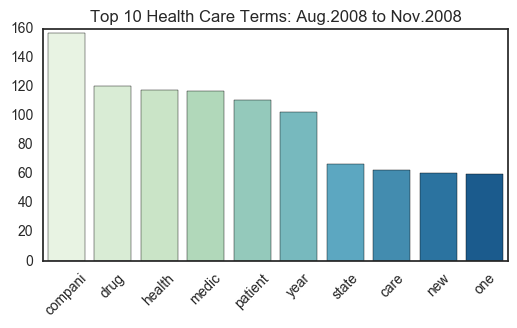

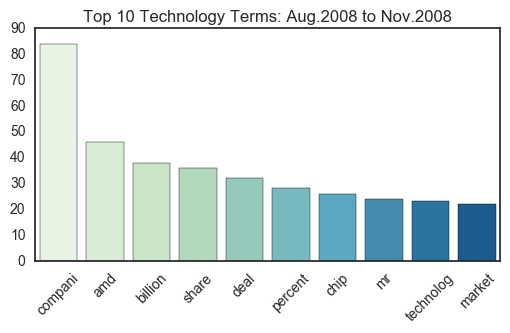

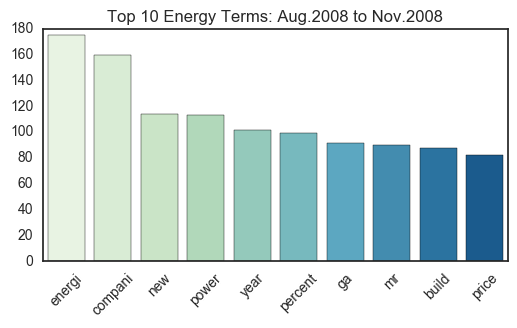

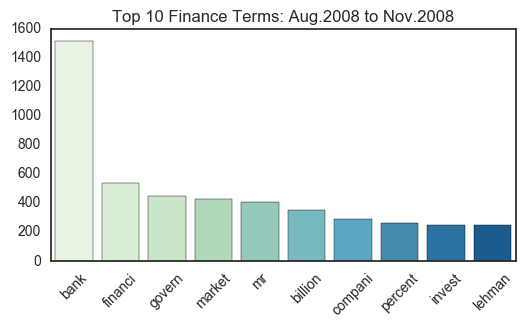

In [96]:
# Create frequency bar plots for the news articles found in Aug2008--Nov2008.
#sns.set_style("dark")
for counter,sector in enumerate(word_freq_list):
    top10 = sorted(sector.items(), key=lambda kv: kv[1], reverse=True)[:10]
    terms,frequency = zip(*top10)
    current_sect = all_news.Sector.unique()[counter]
    plt.figure(counter,figsize=(6,3))
    freq_plot = sns.barplot(terms,frequency,palette='GnBu')
    freq_plot.set_title("Top 10 %s Terms: Aug.2008 to Nov.2008"%current_sect)
    for item in freq_plot.get_xticklabels():
        item.set_rotation(45) 

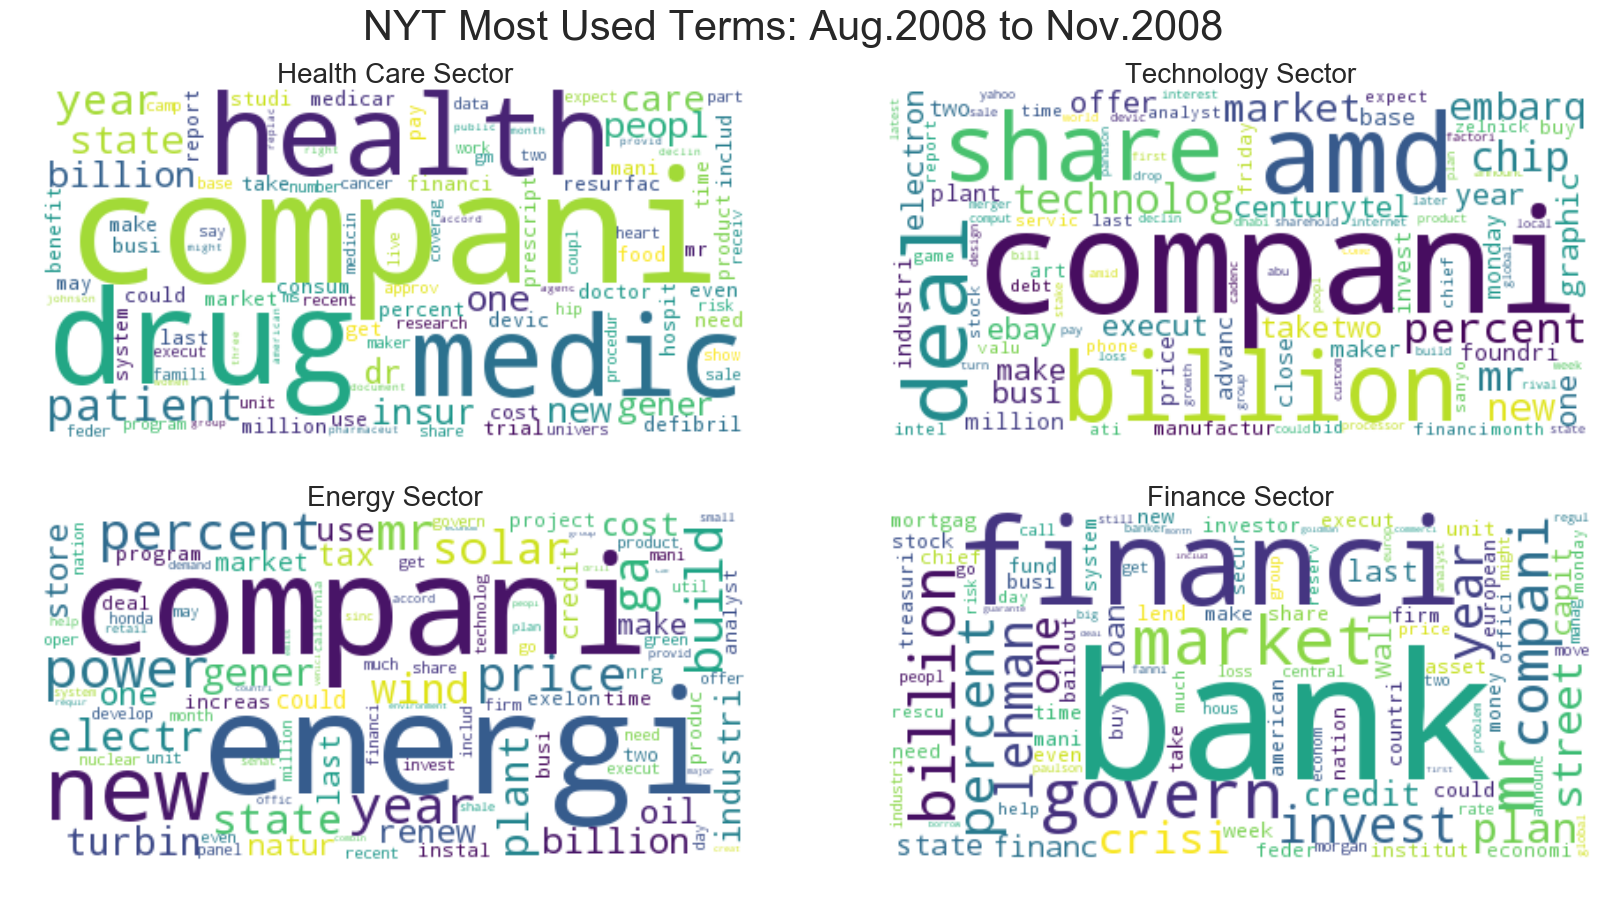

In [99]:
# Support the frequency plot with a word cloud.
fig = plt.figure(figsize=(20,10))
fig.suptitle("NYT Most Used Terms: Aug.2008 to Nov.2008", fontsize=30)
cloud = wordcloud.WordCloud(background_color="white")
for counter, sect in enumerate(word_freq_list):
    current_sect = all_news.Sector.unique()[counter]
    wc = cloud.generate_from_frequencies(sect)
    ax = fig.add_subplot(2,2,counter+1)
    ax.set_title("%s Sector" %current_sect,fontsize=20)
    plt.imshow(wc,aspect='auto')
    plt.axis("off")

###### Note: The plotted terms are stemmed to omit any possible duplicates in the analysis.
Each sector has several key words that dominate their respective domains.  Because these articles were originally collected using certain search parameters for the New York Times API, some terms (i.e. the sector names themselves) are unfortunately overrepresented. However, this design did not prevent other terms from taking the number one spot on the frequency plots. For example, "bank" tops the Financial plots with almost triple the frequency of the second most common term. 

Notably, there are very few instances of term overlap. For example, it is clear that "compani" (assumably "company") is a commonly used word in articles from all sectors. Aside from this instance, it can be argued that the news articles from each sector are unique and distinguishable in their vocabulary.

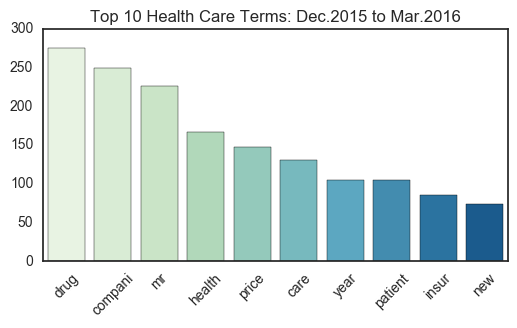

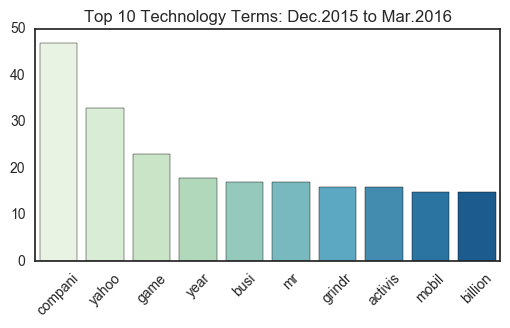

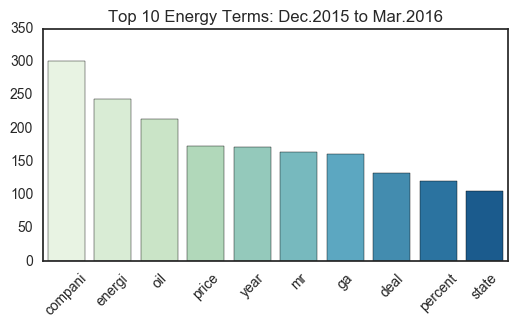

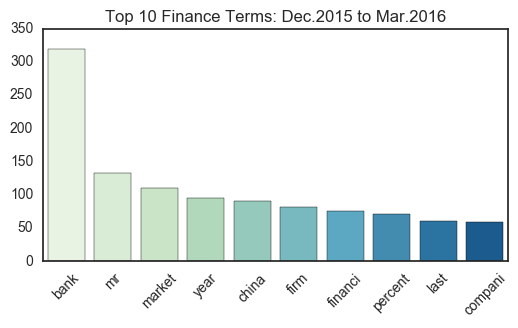

In [127]:
# Create frequency bar plots for the news articles found in Dec2015--Mar2016.
for counter,sector in enumerate(word_freq_list2):
    top10 = sorted(sector.items(), key=lambda kv: kv[1], reverse=True)[:10]
    terms,frequency = zip(*top10)
    current_sect = all_news.Sector.unique()[counter]
    plt.figure(counter,figsize=(6,3))
    freq_plot = sns.barplot(terms,frequency,palette='GnBu')
    freq_plot.set_title("Top 10 %s Terms: Dec.2015 to Mar.2016"%current_sect)
    for item in freq_plot.get_xticklabels():
        item.set_rotation(45) 

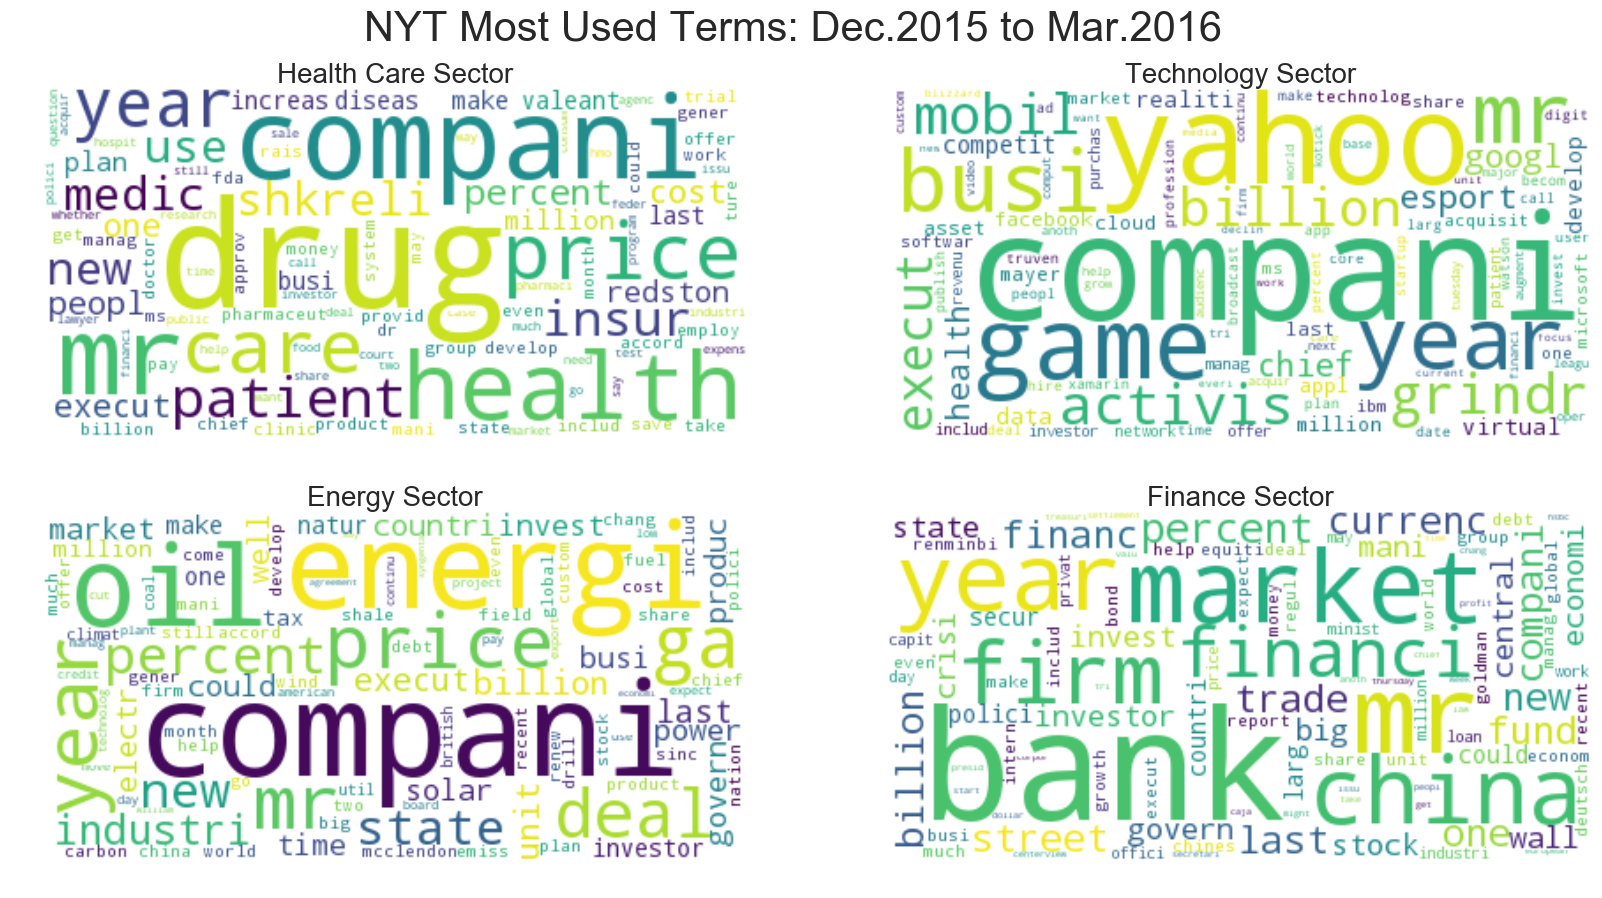

In [128]:
# Support the frequency plot with a word cloud.
fig = plt.figure(figsize=(20,10))
fig.suptitle("NYT Most Used Terms: Dec.2015 to Mar.2016", fontsize=30)
cloud = wordcloud.WordCloud(background_color="white")
for counter, sect in enumerate(word_freq_list2):
    current_sect = all_news.Sector.unique()[counter]
    wc = cloud.generate_from_frequencies(sect)
    ax = fig.add_subplot(2,2,counter+1)
    ax.set_title("%s Sector" %current_sect,fontsize=20)
    plt.imshow(wc,aspect='auto')
    plt.axis("off")

###### Some observable differences exist between the first set (2008) and the second set (2015-2016). 
Though the most used terms remain more or less the same, a noticable change in vocabulary occurs in the Technology sector. For one, more companies are named explicity, with Yahoo and Grindr taking spots in the top 10 (on the word cloud, companies like Google and Apple make an appearance as well). In addition, the terms on this 2015-2016 word cloud seem to exclude "business terms" such as "share","deal",and "market", all of which were in the top 10 of the 2008 articles. 

Yet for the other sectors, many of the major terms remain the same; "compani" remains in the first or second spot for Health Care, Tech, and Energy, and "bank" continues to dominate Finance. Thus, the terms that convey the most information likely exist somewhere in between the top 10 to 100 unigrams collected, as words like "game" and "esport" become more popular the Tech industry, and entities like China make their way into financial news. Overall, though the difference here is only a few years, the changes in term frequency may correspond to a shift in industry interests.

# Time Series Analysis

In [132]:
ts_eng = delta_df['Energy Changes']
# Why do we get an NA for Nov 1 2016?
# Need to change following date range
# ts_eng['2016-11-02':'2017-03-01']

## Check Stationarity

Dickey-Fuller Test: tests the null hypothesis of whether a u nit root is present in an autoregressive model.  

In [133]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=12)
    rolstd = pd.rolling_std(timeseries, window=12)

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)


test_stationarity(ts_eng)

In [134]:
testE = delta_df["Energy Changes"]

# Energy Sector Time Series

In [135]:
E_log = np.log(med_T.iloc[-365:,:]['Health Care'])

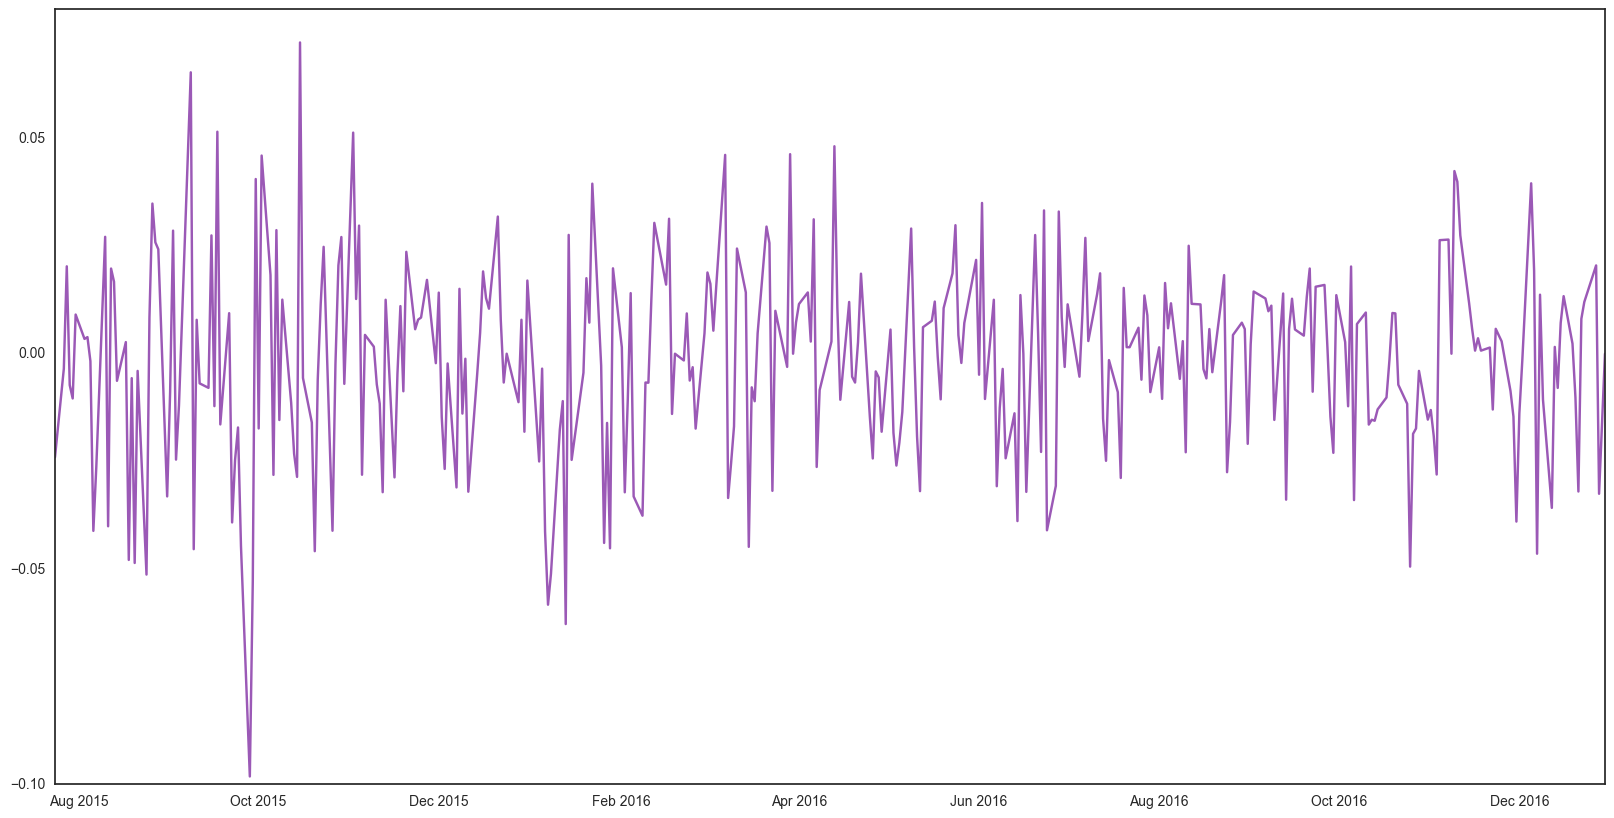

In [136]:
E_log_diff = E_log - E_log.shift()
plt.plot(E_log_diff)

(-0.15, 0.15)

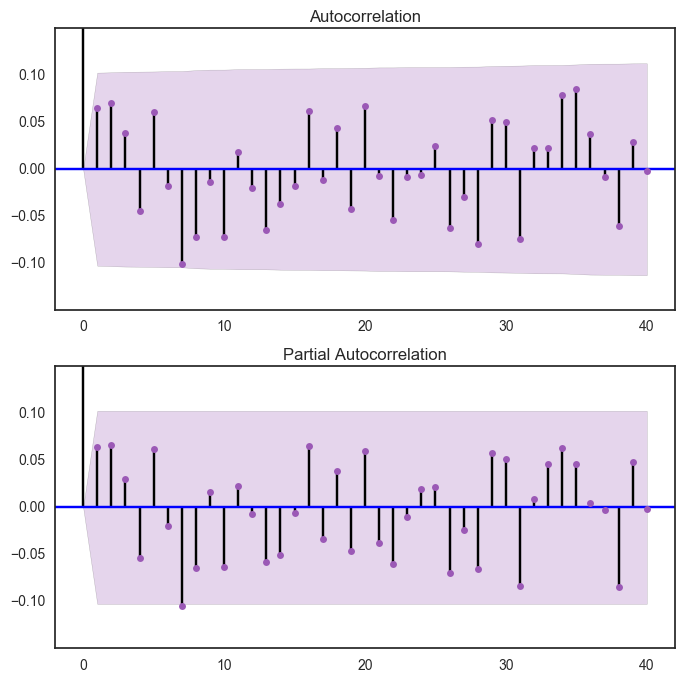

In [137]:
fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(211) 
fig = sm.graphics.tsa.plot_acf(E_log_diff[1:].values.squeeze(),lags = 40,ax=ax1)
plt.ylim([-0.15,0.15])
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(E_log_diff[1:],lags =40, ax= ax2)
plt.ylim([-0.15,0.15])

/Users/Homieknights/anaconda/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:5: FutureWarning:

pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()

/Users/Homieknights/anaconda/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning:

pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()



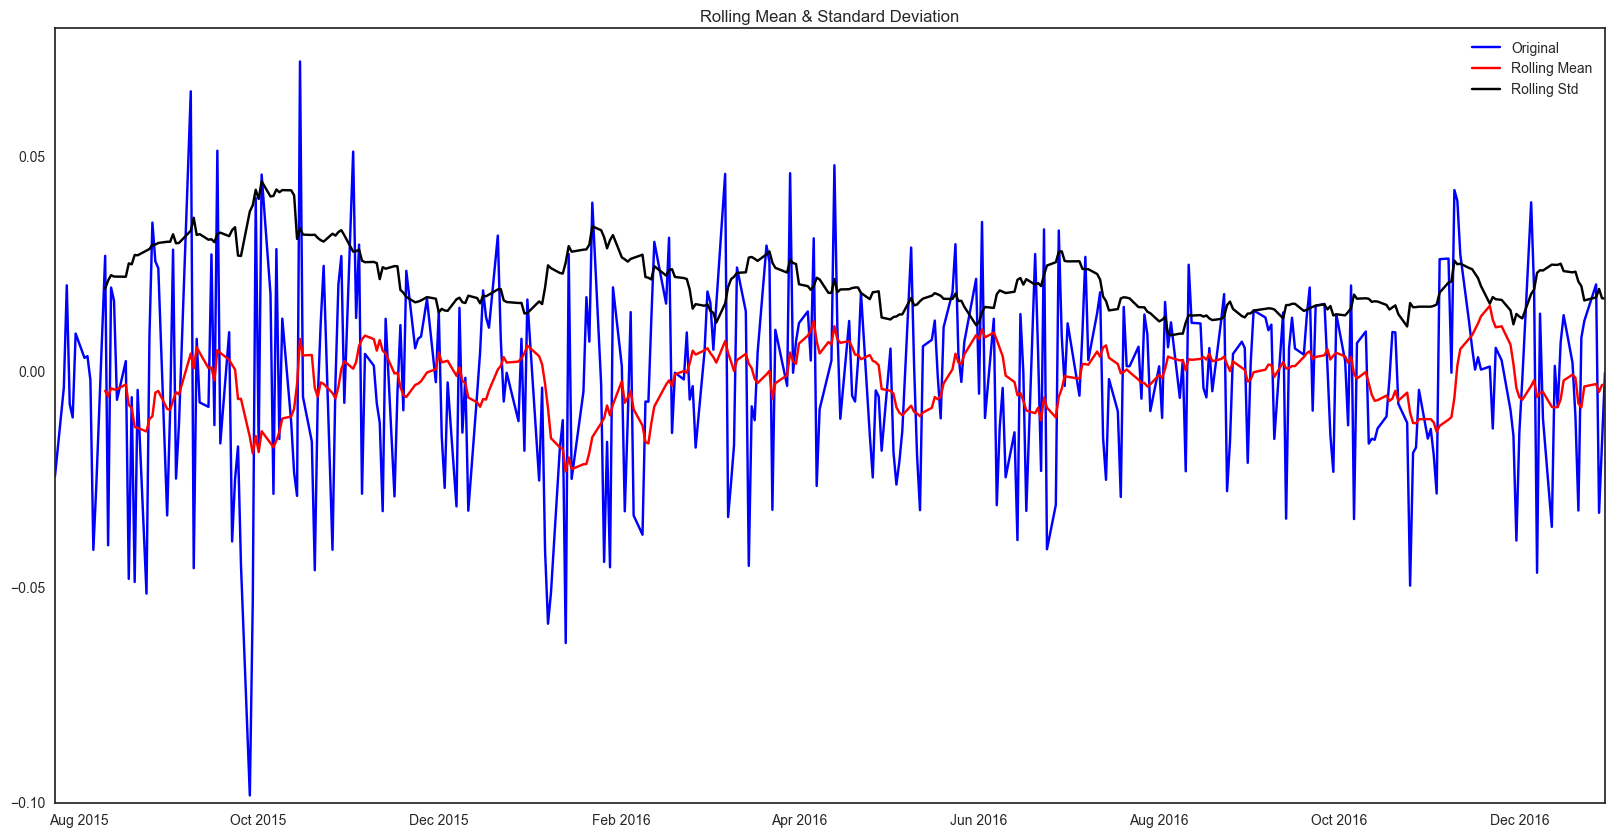

Results of Dickey-Fuller Test:
Test Statistic                -1.783212e+01
p-value                        3.130286e-30
#Lags Used                     0.000000e+00
Number of Observations Used    3.630000e+02
Critical Value (5%)           -2.869535e+00
Critical Value (1%)           -3.448494e+00
Critical Value (10%)          -2.571029e+00
dtype: float64


In [138]:
E_log_diff.dropna(inplace=True)
test_stationarity(E_log_diff)